# Create data structure to inform GCPN loss function using KG-COVID-19 embeddings

In this notebook, we make a data structure to be used to inform a GCPN loss function with
information from embeddings of the KG-COVID-19 knowledge graph. This graph contains a broad
array of information about COVID-19 and SARS-CoV-2 ([detailed here](https://knowledge-graph-hub.github.io/kg-covid-19-dashboard/)).

The data structure we produce will be a 2D matrix comprised of the 6,900 ChEMBL antiviral compounds as rows,
important SARS-CoV-2 entities represented as nodes in our KG (such as SARS-CoV-2 itself, protein cleavage
products like ADRP and Mpro, etc) as columns. The value in the matrix will be the cosine similarity
between the embedding of the node for the ChEMBL antiviral in the row and the embedding of the node for
the SARS-CoV-2 entity in that column. The matrix will be output as a TSV. The SMILE string representation of each ChEMBL antiviral will also be output as an additional column so that Tanimoto similarity can be calculated.

The data structure produced here will be used to investigate whether embeddings of the COVID-19 KG
can be used to guide GCPNs in producing more useful/viable antivirals for COVID-19 treatment. Specifically,
for each compound produced by GCPN, a loss function might be defined using the product of the Tanimoto similarity and cosine similarity for the ChEMBL antivirals, something like:

$L = -max^{n}_{i=1}(tanimoto(C^{gcpn}, C^{chembl}_i) * cosine\_sim(C^{chembl}_i, N^{interest}))$


where n is the number of ChEMBL antivirals, N is the SARS-CoV-2 node of interest (ADRP, Mpro, SARS-CoV-2 itself, etc) that is to be targeted by the therapeutic.

Conceptually this should confine the GCPN to some boundary of "druglikeness" as defined by similarity to ChEMBL antivirals and their ability to target the drug target of interest.

CAVEAT: These embeddings were generated using an 80/20 training/test split. We could and possibly should regenerate these embeddings with the entire graph (no 80/20 split)

## Loading the KG-COVID-19 knowledge graph
We need to load the graphs and redo the training/test split exactly as we did when generating the embeddings in order to retrieve the labels for the embedddings

### Define all files and URLs up top here

In [1]:
import os

base_dl_dir = "downloaded_data"
graph_data_dir = os.path.join(base_dl_dir, "kg-covid-19-20201001")
embedding_data_dir = os.path.join(base_dl_dir, "embeddings-20201001")

# graph stuff
graph_out_file = os.path.join(graph_data_dir + "/kg-covid-19.tar.gz")
nodes_file = os.path.join(graph_data_dir, "merged-kg_nodes.tsv")
edges_file = os.path.join(graph_data_dir, "merged-kg_edges.tsv")
sorted_edges_file = os.path.join(graph_data_dir, "merged-kg_edges_SORTED.tsv")
graph_tar_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201001/kg-covid-19.tar.gz"

# embeddings URLs
base_kghub_url = "http://kg-hub.berkeleybop.io/"
embeddings_url = os.path.join(base_kghub_url, "embeddings/20201001/SkipGram_80_20_kg_covid_19_20201001_training_test_epoch_500_delta_0.0001_embedding.npy")
embedding_file = os.path.join(embedding_data_dir, "SkipGram_embedding.npy")

# params
seed = 42
train_percentage = 0.8
patience = 5

In [37]:
chembl_antiviral_dir = os.path.join(base_dl_dir, "chembl_antiviral-20201001")
chembl_antiviral_file = os.path.join(chembl_antiviral_dir, "chembl_nodes.tsv")
chembl_antiviral_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201001/transformed/ChEMBL/nodes.tsv"

chembl_prefix = 'CHEMBL.COMPOUND'

In [3]:
from pkg_resources import get_distribution
assert(get_distribution("ensmallen-graph").version == '0.4.3')
assert(get_distribution("embiggen").version == '0.6.0')

In [4]:
# download the graphs, if necessary

import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)

if not os.path.exists(nodes_file) or not os.path.exists(edges_file):
    with urllib.request.urlopen(graph_tar_url) as response, \
        open(graph_out_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)
    os.system("tar -xvzf " + graph_out_file + " -C " + graph_data_dir)

## Retrieve the embeddings

In [5]:
os.makedirs(embedding_data_dir, exist_ok=True)

if not os.path.exists(embedding_file):
    with urllib.request.urlopen(embeddings_url) as response, \
        open(embedding_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [6]:
%%time
from ensmallen_graph import EnsmallenGraph

if not os.path.exists(sorted_edges_file):
    graph = EnsmallenGraph.from_unsorted_csv(
        edge_path = edges_file,
        sources_column="subject",
        destinations_column="object",
        directed=False,
        node_path = nodes_file,
        nodes_column = 'id',
        node_types_column = 'category',
        default_node_type = 'biolink:NamedThing'
    )

    graph.dump_edges(sorted_edges_file,
        sources_column="subject",
        destinations_column="object")

CPU times: user 1.43 ms, sys: 1.25 ms, total: 2.69 ms
Wall time: 3.43 ms


In [7]:
from ensmallen_graph import EnsmallenGraph

graph = EnsmallenGraph.from_sorted_csv(
    edge_path = sorted_edges_file,
    sources_column="subject",
    destinations_column="object",
    directed=False,
    nodes_number=377577,  # should be = or > than actual number
    edges_number=30949369,   # same ^
    node_path = nodes_file,
    nodes_column = 'id',
    node_types_column = 'category',
    default_node_type = 'biolink:NamedThing'
)

graph.report()

{'self_loops_rate': '0.00001554151233261008',
 'nodes_number': '377577',
 'singletons': '8314',
 'directed': 'false',
 'unique_edge_types_number': '0',
 'self_loops_number': '481',
 'degree_mean': '81.96836406878597',
 'edges_number': '30949369',
 'density': '0.037284237441157525',
 'unique_node_types_number': '37'}

In [8]:
%%time
pos_training, pos_validation = graph.connected_holdout(train_percentage, seed=seed)

CPU times: user 2min 28s, sys: 3.07 s, total: 2min 31s
Wall time: 2min 33s


The followings checks are not strictly necessary, but are offered as sanity checks:

In [9]:
%%time
coherence_check=False
if coherence_check:
    assert graph.contains(pos_training)
    assert graph.contains(pos_validation)
    assert (pos_training | pos_validation).contains(graph)
    assert graph.contains(pos_training | pos_validation)
    assert not training.overlaps(pos_validation)
    assert not validation.overlaps(pos_training)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [10]:
import numpy as np
embeddings = np.load(embedding_file)

In [11]:
node_names = list(np.array(pos_training.get_nodes_reverse_mapping()))

In [12]:
assert len(pos_training.get_nodes_reverse_mapping()) == len(embeddings)

In [13]:
assert len(pos_training.get_node_types()) == len(embeddings)

### Okay, right now there are two nodes in the graph representing SARS-CoV-2, due to how external DBs refer to this virus. We'll add both here, but in tests, I'd recommend using 'CHEMBL.TARGET:CHEMBL4303835'

In [118]:
sars_cov_2_curie = 'CHEMBL.TARGET:CHEMBL4303835'
sars_cov_2_curie_alt = 'NCBITaxon:2697049'

### add the graph nodes representating SARS-CoV-2 as a column (nodes of interest)

In [120]:
nodes_of_interest = [
    {'name': 'SARS-CoV-2',
     'curie': sars_cov_2_curie,
     'node_id': node_names.index(sars_cov_2_curie),
    },
    {'name': 'SARS-CoV-2 (alternate node)',
     'curie': sars_cov_2_curie_alt,
     'node_id': node_names.index(sars_cov_2_curie_alt),
    },
]

### add graph nodes for all SARS-CoV-2 proteins/cleavage products as columns too

In [121]:
import wget

if not os.path.exists("uniprot_sars-cov-2.gpi"):
    url = "https://raw.githubusercontent.com/Knowledge-Graph-Hub/kg-covid-19/master/curated/ORFs/uniprot_sars-cov-2.gpi"
    filename = wget.download(url)

with open("uniprot_sars-cov-2.gpi", 'r') as gpi:
    lines = gpi.readlines()
    # print("NAME\tDB ID")
    for line in lines:
        if line.startswith("!"):
            continue
        fields = line.split("\t")
        this_curie = ":".join([fields[0], fields[1]])
        nodes_of_interest.append({'name': fields[2],
                                  'curie': this_curie,
                                  'node_id': node_names.index(this_curie)
                                 })
        # print("%s\t%s" % (fields[2], ":".join([fields[0], fields[1]])))

In [42]:
# get chembl antiviral nodes file
import wget

os.makedirs(chembl_antiviral_dir, exist_ok=True)

if not os.path.exists(chembl_antiviral_file):
    filename = wget.download(chembl_antiviral_url, chembl_antiviral_file)

In [227]:
import re

chembl_antiviral_curies = []
chembl_antiviral_names = []


with open(chembl_antiviral_file, 'r') as f:
    header = f.readline().split("\t")
    while line := f.readline():
        items = line.split("\t")
        this_id = items[header.index("id")]
        this_name = items[header.index("name")]
        if re.match(chembl_prefix, this_id):
            chembl_antiviral_curies.append(this_id)
            chembl_antiviral_names.append(this_name)

In [20]:
# import re
# chembl_prefix = 'CHEMBL.COMPOUND'
# chembl_names = [x for x in node_names if (match := re.compile(chembl_prefix).search(x))]
# chembl_idx = [index for index, x in enumerate(node_names) if (match := re.compile(chembl_prefix).search(x))]
# len(chembl_names)

In [ ]:
chembl_antiviral_cosine_sim = np.full((len(chembl_antiviral_idx), len(nodes_of_interest)), -1000.0000)

# precompute node idx to speed things up
chembl_antiviral_node_idx = [node_names.index(i) for i in chembl_antiviral_curies]
nodes_of_interest_node_idx = [node_names.index(i.get("curie")) for i in nodes_of_interest]

for i, antiviral_curie in tqdm(enumerate(chembl_antiviral_curies)):
    for j, node_of_interest in enumerate(nodes_of_interest):
        antiviral_emb = embeddings[chembl_antiviral_node_idx[i]]
        noi_emb = embeddings[nodes_of_interest_node_idx[j]]
        chembl_antiviral_cosine_sim[i,j] = 1 - spatial.distance.cosine(antiviral_emb, noi_emb)

In [ ]:
# why not
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(chembl_antiviral_cosine_sim, cmap='jet', aspect='auto')
plt.title("Cosine similarity - ChEMBL antivirals vs SARS-CoV-2")
plt.xlabel('SARS-CoV-2', fontsize=18)
plt.ylabel('ChEMBL antivirals', fontsize=16)
plt.xticks(ticks=np.arange(len(nodes_of_interest)),
           labels=[n.get('name') for n in nodes_of_interest],
           rotation=90
          )
plt.savefig('chembl_vs_sars_cosine_sim.pdf')
plt.show()


In [ ]:
z = chembl_antiviral_cosine_sim.copy()
z[z < 0] = 0

plt.imshow(z, cmap='jet', aspect='auto')
plt.title("Cosine similarity - ChEMBL antivirals vs SARS-CoV-2")
plt.xlabel('SARS-CoV-2', fontsize=18)
plt.ylabel('ChEMBL antivirals', fontsize=16)
plt.xticks(ticks=np.arange(len(nodes_of_interest)),
           labels=[n.get('name') for n in nodes_of_interest],
           rotation=90)
plt.show()

In [ ]:
chembl_antivirals_ranked_by_sars_cov_2 = [[x,y] for y,x in sorted(zip(chembl_antiviral_cosine_sim[:,0],chembl_antiviral_names), reverse=True)]

In [ ]:
chembl_antivirals_ranked_by_sars_cov_2_alt = [[x,y] for y,x in sorted(zip(chembl_antiviral_cosine_sim[:,1],chembl_antiviral_names), reverse=True)]

In [ ]:
chembl_antivirals_ranked_by_sars_cov_2_both = [[x,y] for y,x in sorted(zip(chembl_antiviral_cosine_sim[:,0]*chembl_antiviral_cosine_sim[:,1],chembl_antiviral_names), reverse=True)]

In [ ]:
chembl_antivirals_ranked_by_sars_cov_2_both

In [ ]:
1 - spatial.distance.cosine(antiviral_emb, noi_emb)

In [213]:
1 - spatial.distance.cosine(antiviral_emb, noi_emb)

6900it [00:11, 592.35it/s]


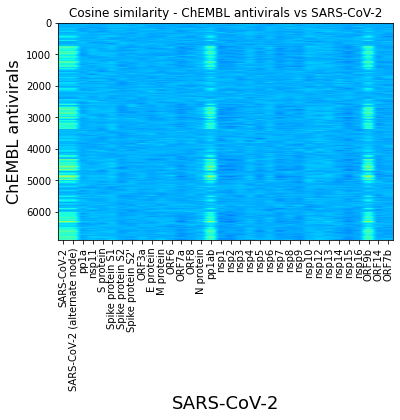

In [271]:
# why not
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(chembl_antiviral_cosine_sim, cmap='jet', aspect='auto')
plt.title("Cosine similarity - ChEMBL antivirals vs SARS-CoV-2")
plt.xlabel('SARS-CoV-2', fontsize=18)
plt.ylabel('ChEMBL antivirals', fontsize=16)
plt.xticks(ticks=np.arange(len(nodes_of_interest)),
           labels=[n.get('name') for n in nodes_of_interest],
           rotation=90
          )
plt.savefig('chembl_vs_sars_cosine_sim.pdf')
plt.show()


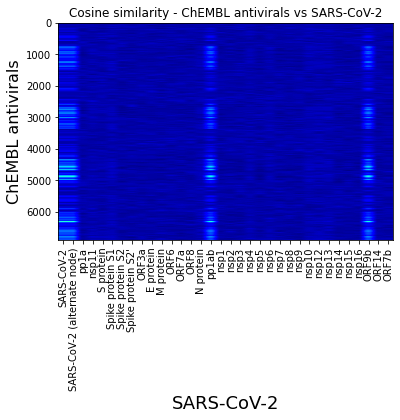

In [221]:
z = chembl_antiviral_cosine_sim.copy()
z[z < 0] = 0

plt.imshow(z, cmap='jet', aspect='auto')
plt.title("Cosine similarity - ChEMBL antivirals vs SARS-CoV-2")
plt.xlabel('SARS-CoV-2', fontsize=18)
plt.ylabel('ChEMBL antivirals', fontsize=16)
plt.xticks(ticks=np.arange(len(nodes_of_interest)),
           labels=[n.get('name') for n in nodes_of_interest],
           rotation=90)
plt.show()

In [264]:
chembl_antivirals_ranked_by_sars_cov_2 = [[x,y] for y,x in sorted(zip(chembl_antiviral_cosine_sim[:,0],chembl_antiviral_names), reverse=True)]

In [269]:
chembl_antivirals_ranked_by_sars_cov_2_alt = [[x,y] for y,x in sorted(zip(chembl_antiviral_cosine_sim[:,1],chembl_antiviral_names), reverse=True)]

In [268]:
chembl_antivirals_ranked_by_sars_cov_2_both = [[x,y] for y,x in sorted(zip(chembl_antiviral_cosine_sim[:,0]*chembl_antiviral_cosine_sim[:,1],chembl_antiviral_names), reverse=True)]

In [270]:
chembl_antivirals_ranked_by_sars_cov_2_both

[['SUNITINIB', 0.9916420343096988],
 ['LOPINAVIR', 0.9914310365435846],
 ['FLUDARABINE PHOSPHATE', 0.9913783887870409],
 ['OSELTAMIVIR CARBOXYLIC ACID', 0.9913640525169853],
 ['FLUTICASONE PROPIONATE', 0.9913490754908025],
 ['GEFITINIB', 0.9913093965702728],
 ['REMDESIVIR', 0.9913082965825311],
 ['CHLORAMPHENICOL', 0.9912615032178529],
 ['RITONAVIR', 0.9911803999642288],
 ['IMATINIB', 0.9911345007232804],
 ['CEFTRIAXONE', 0.9911177698005602],
 ['TOPOTECAN', 0.9910534748277726],
 ['FOLIC ACID', 0.9910013080468261],
 ['VORICONAZOLE', 0.9909602921478751],
 ['CITRIC ACID', 0.9909039944968683],
 ['CLINDAMYCIN', 0.9908667052661535],
 ['GLUTAMINE', 0.9907415444425283],
 ['GAMMA-AMINOBUTYRIC ACID', 0.990739307993028],
 ['CYCLOPHOSPHAMIDE', 0.9907179812049378],
 ['ASPIRIN', 0.9906234944427403],
 ['ACETAMINOPHEN', 0.9905966178456538],
 ['DIDANOSINE', 0.9905395898983365],
 ['MG-132', 0.9904691933661383],
 ['RIFAMPIN', 0.9904573947898996],
 ['AMANTADINE', 0.9904507552388253],
 ['CHLORHEXIDINE', 0.

In [262]:
1 - spatial.distance.cosine(antiviral_emb, noi_emb)

0.06533835828304291